In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")

Using device: cuda

TITAN Xp
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import functools
from PIL import Image
import argparse
import os
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

In [4]:
from PIL import Image
from torchvision import transforms
from core.ofa import OFATokenizer, OFAModel
from core.ofa.generate import sequence_generator

In [14]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset, VqaStackDataset
from core.ofa.label_smoothed_cross_entropy import AdjustLabelSmoothedCrossEntropyCriterion
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig
from accelerate import Accelerator
from accelerate.utils import DistributedDataParallelKwargs
from accelerate import DistributedType

In [6]:
import transformers

## Convert pt to pretrained bin

In [8]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/base_vqa/ofa_vqa.14500.pt"


In [9]:
kwargs = DistributedDataParallelKwargs(find_unused_parameters = True)
accelerator = Accelerator(kwargs_handlers = [kwargs])

In [10]:
# fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/results/ofa_vqa.32000.pt"
pkg = torch.load(fine_tuned, map_location = 'cpu')

In [11]:
ofa_config = OFAConfig.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-base-vqa/')
vqa_model = OFAModelForVQA(ofa_config)

/srv/share2/sanisetty3/miniconda3/envs/ai-choreo/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
unwrapped_model = accelerator.unwrap_model(vqa_model)

In [13]:
unwrapped_model.load_state_dict(pkg['model'])

<All keys matched successfully>

In [14]:
unwrapped_model.save_pretrained('/coc/scratch/sanisetty3/DLM/ofa-base-vqa/', save_function=accelerator.save)

##  Weight transfer to transformer model

In [79]:
model_b = OFAModelForVQA.from_pretrained("OFA-base/", use_cache=False)


In [81]:
base = torch.load("OFA-base/pytorch_model.bin")

In [172]:
base_vqa = torch.load("vqa_base_best.pt")["model"]
del base_vqa["encoder.version"]
del base_vqa["decoder.version"]

In [173]:
def change_key(self, old, new):
    for _ in range(len(self)):
        k, v = self.popitem(False)
        self[new if old == k else k] = v

In [174]:
 my_dic_keys = list(base_vqa.keys())

In [175]:
for i in my_dic_keys:
#     print(i)
    if "ffn_layernorm" in i and "encoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
    if "attn_ln" in i and "encoder" in i:
        new = str(i).replace("attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
        
    if "encoder_attn" in i and "decoder" in i:
        new = str(i).replace("encoder_attn","cross_attn")
        change_key(base_vqa , i , new)
        
    if "ffn_layernorm" in i and "decoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "cross_attn_ln" in i and "decoder" in i:
        new = str(i).replace("cross_attn_ln","cross_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "self_attn_ln" in i and "decoder" in i:
        new = str(i).replace("self_attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 

encoder.layers.0.attn_ln.weight
encoder.layers.0.attn_ln.bias
encoder.layers.0.ffn_layernorm.weight
encoder.layers.0.ffn_layernorm.bias
encoder.layers.1.attn_ln.weight
encoder.layers.1.attn_ln.bias
encoder.layers.1.ffn_layernorm.weight
encoder.layers.1.ffn_layernorm.bias
encoder.layers.2.attn_ln.weight
encoder.layers.2.attn_ln.bias
encoder.layers.2.ffn_layernorm.weight
encoder.layers.2.ffn_layernorm.bias
encoder.layers.3.attn_ln.weight
encoder.layers.3.attn_ln.bias
encoder.layers.3.ffn_layernorm.weight
encoder.layers.3.ffn_layernorm.bias
encoder.layers.4.attn_ln.weight
encoder.layers.4.attn_ln.bias
encoder.layers.4.ffn_layernorm.weight
encoder.layers.4.ffn_layernorm.bias
encoder.layers.5.attn_ln.weight
encoder.layers.5.attn_ln.bias
encoder.layers.5.ffn_layernorm.weight
encoder.layers.5.ffn_layernorm.bias


In [176]:
mis = []
for i in (base_vqa.keys()):
    
    if i in base.keys():
        continue
    else:
        print(i)
        mis.append(i)

len(mis)

0

In [177]:
torch.save(base_vqa , "OFA-base-vqa/pytorch_model.bin")

In [178]:
model_p = OFAModelForVQA.from_pretrained("OFA-base-vqa/", use_cache=False)


## Test VQAv2

In [7]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)


NameError: name 'pretrained' is not defined

In [ ]:
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)
model_f = OFAModelForVQA.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-tiny-fine-tune/', use_cache=False)

In [ ]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

In [155]:
ann_file = os.path.join('/srv/scratch/sanisetty3/DLM/AliceMind/mPLUG/data/json/vqa_ocr_object/' ,"vqa_train_ocr.json")
vqa_root = '/srv/datasets/coco/'


In [156]:
ds = VqaDataset(
    ann_file=[ann_file],
    vqa_root=vqa_root,
)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 8, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [157]:
for batch in dl:
    break

In [158]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' what fruit is growing on the bush?', ' is the horse outside?', ' is the saddle western?', ' how many frisbees is the man holding?', ' what is his name?', ' where is the clock?', ' does the tennis player have an audience?', ' what are the men looking at online?']


In [159]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['oranges', 'yes', 'yes', '2', 'lin', 'table', 'no', 'work']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


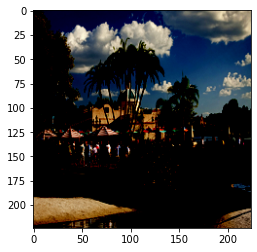

In [160]:
plt.imshow(batch["patch_images"][0].permute(1,2,0).cpu().numpy())

## Test Stack

In [7]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa/'

In [8]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False)


In [10]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [11]:
from core.datasets.vqa_gen_dataset import VQACollator, VqaDataset,VqaStackDataset,CLEVRVQADataset


In [226]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/Relational_dataset/stack_train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/Relational_dataset/images"

In [122]:
ds = VqaStackDataset(
    ann_file=ann_file,
    vqa_root=vqa_root,
)
stack_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
stack_dl = DataLoader(ds, batch_size = 8, collate_fn=stack_data_collator ,num_workers = 0, shuffle = True)


/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [227]:
ds = CLEVRVQADataset(split="valA")
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [228]:
len(ds)

150000

In [146]:
for batch in dl:
    break

In [147]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' the rubber block that is both to the right of the yellow matte thing and in front of the big red object is what color?', ' there is a purple shiny thing that is behind the matte thing; does it have the same shape as the large metal object that is behind the purple shiny cylinder?', ' the sphere that is both behind the shiny cube and left of the large red metallic object is what color?', ' how many things are behind the blue metallic ball and on the right side of the large gray thing?', ' what size is the red ball behind the gray metal object that is in front of the large red rubber object that is in front of the big shiny block?', ' is the number of big yellow blocks that are in front of the tiny red shiny thing greater than the number of tiny brown matte cubes?', ' are there fewer yellow metallic things to the right of the large green thing than tiny balls?', ' there is a tiny shiny object to the left of the small cyan metallic thing; does it have the same color as the big metal ob

In [148]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['gray', 'yes', 'brown', '0', 'large', 'no', 'yes', 'no']


### Pretrained

In [149]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['gray', 'yes', 'brown', '0', 'large', 'no', 'yes', 'no']


In [150]:
gen = model_p.generate(batch["input_ids"], patch_images=batch["patch_images"], num_beams=5, no_repeat_ngram_size=3)

In [151]:
tokenizer_p.batch_decode(gen, skip_special_tokens=True)

[' red', ' no', ' green', ' 2', ' large', ' yes', ' yes', ' yes']

In [152]:
indx = 2
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]

question:  the sphere that is both behind the shiny cube and left of the large red metallic object is what color?
pred:  green
target:  brown


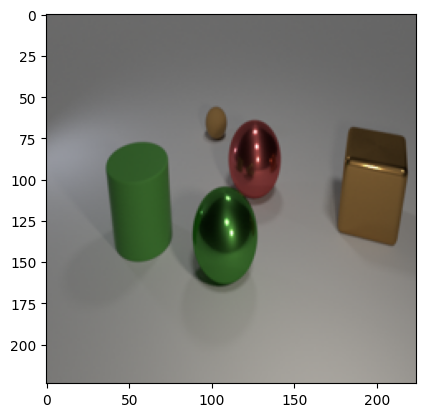

In [153]:
plt.imshow(img)
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

### Finetuned

In [154]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['gray', 'yes', 'brown', '0', 'large', 'no', 'yes', 'no']


In [155]:
gen_fin = model_f.generate(batch["input_ids"], patch_images=batch["patch_images"], num_beams=5, no_repeat_ngram_size=3)

In [156]:
tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)

['gray', 'no', 'brown', '0', 'large', 'no', 'yes', 'no']

question:  the sphere that is both behind the shiny cube and left of the large red metallic object is what color?
pred:  brown
target:  brown


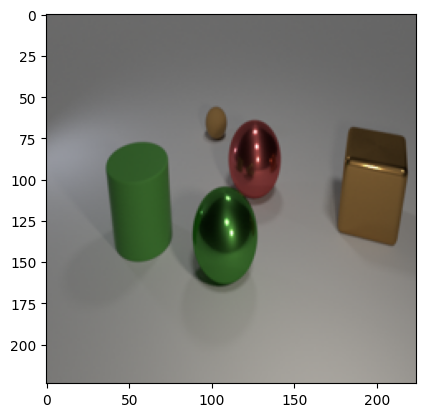

In [157]:
plt.imshow(img)
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

## Eval script

In [37]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset, VqaStackDataset, CLEVRVQADataset


In [7]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa/'

In [11]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [12]:
model_f.device

device(type='cuda', index=0)

In [15]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/Relational_dataset/stack_train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/Relational_dataset/images"

ds = VqaStackDataset(
    ann_file=ann_file,
    vqa_root=vqa_root,
)
stack_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
stack_dl = DataLoader(ds, batch_size = 8, collate_fn=stack_data_collator ,num_workers = 0, shuffle = True)


/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [67]:
ds = CLEVRVQADataset(split="valA")
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = False)


In [72]:
def cycle(dl):
    while True:
        for data in dl:
            yield data

In [77]:
from tqdm import tqdm

targets = []
pred = []
i = 0

itr = cycle(stack_dl)

for i in tqdm(range(200)):

    batch = next(itr)
#     try:
        
    gen_fin = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
    pred.append(gen_fin)
    targets.append(batch["target"])
#     except:
#         continue
    
    
    

100%|████████████████████████████████████████████████████████| 200/200 [03:12<00:00,  1.04it/s]


In [78]:
len(pred)

200

In [79]:
count = 0
for i in range(len(pred)):
#     print(i)
    for j in range(10):
#         print(np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2]))
        try:
            trs = int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])))
            count+=trs
        except:
            continue
count/(10*len(pred))

/tmp/ipykernel_25237/1424390811.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  trs = int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])))


0.0

In [76]:
for i in zip(targets , pred):
    print(tokenizer_p.batch_decode(i[0], skip_special_tokens=True))
    print(tokenizer_p.batch_decode(i[1], skip_special_tokens=True))
    print("\n")

['yes', 'rubber', 'metal', 'no', '2', '0', 'small', '2', 'no', 'cylinder']
[' yes yes yes no no no yes yesno no nono yes no yes nono no', ' metal', ' plastic', ' no', ' 2', ' 2', ' large red rubber duck', ' 3', ' no', ' round']


['yes', 'no', '5', 'small', 'no', 'yes', 'yes', '2', '0', 'yes']
[' no', ' no', ' 2', ' large brown block small', ' no', ' yes', ' yes yes yes no no no yes nono no nono yes no yes yesno no', ' 2', ' 2', ' no']


['yes', 'no', 'no', 'cube', 'purple', 'no', 'metal', 'yes', 'red', 'yes']
[' no', ' no', ' no', ' square', ' blue', ' yes', ' plastic', ' yes', ' green', ' yes']


['large', 'purple', '3', '1', 'metal', '1', 'cube', 'yes', '9', '4']
[' small', ' red', ' 2', ' 2', ' plastic', ' 5', ' square', ' yes', ' 1', ' 3']


['1', 'small', 'no', '0', 'cube', 'yes', 'no', '1', 'no', 'yes']
[' 2', ' small', ' yes', ' big blocks', ' square', ' yes', ' yes', ' 2', ' no', ' no']


['yes', 'yes', 'yellow', 'green', 'cube', 'metal', 'yes', 'yellow', '5', 'large']
[' no',

['yes', 'no', 'cyan', 'brown', 'large', 'cylinder', 'metal', 'yes', 'cyan', '0']
[' no', ' no', ' silver', ' yellow', ' large', ' round', ' plastic', ' no', ' silver', ' 3']


['small', 'yes', 'rubber', 'yes', '4', '0', '2', 'no', '2', 'no']
[' small', ' no', ' metal', ' no', ' 4', ' 1', ' 5', ' yes', ' 2', ' no']


['cube', 'no', 'yes', 'yes', '0', 'metal', 'metal', 'yes', 'no', 'yes']
[' square', ' no', ' no', ' no', ' 4', ' plastic', ' plastic', ' no', ' no', ' no']


['yellow', 'no', 'large', 'no', 'cube', 'cube', '1', 'green', 'large', 'yes']
[' green', ' yes', ' small', ' yes', ' square', ' square', ' 2', ' green', ' very big', ' yes']


['no', 'rubber', 'no', '2', '1', 'large', '4', 'cylinder', 'no', 'no']
[' yes yes yes no no no yes no yesno no nono yes nono no yes', ' plastic', ' no', ' 1', ' 1', ' large', ' 3', ' circle', ' no', ' no']


['no', 'metal', 'rubber', 'yes', '1', '0', 'small', '2', 'no', 'cylinder']
[' yes', ' plastic', ' plastic', ' no', ' 2', ' 2', ' large green

[' no', ' plastic', ' plastic', ' no', ' 2', ' 2', ' yes', ' 5', ' no', ' purple spheres on the left of red metal ball sphere']


['yes', 'yes', '6', 'large', 'no', 'yes', 'no', '2', '3', 'yes']
[' yes', ' no', ' 5', ' very big', ' no', ' yes', ' no', ' 3', ' 3', ' yes']


['no', 'no', 'no', 'cylinder', 'green', 'yes', 'rubber', 'yes', 'yellow', 'no']
[' no', ' no', ' no', ' round', ' yes', ' no', ' metal', ' no', ' green', ' no']


['small', 'green', '1', '1', 'rubber', '1', 'cylinder', 'no', '9', '4']
[' yes', ' green', ' 2', ' 2', ' plastic', ' 5', ' round', ' no', ' 3', ' 3']


['2', 'large', 'yes', '0', 'cube', 'yes', 'no', '0', 'no', 'no']
[' 3', ' large silver cube in front of green thing', ' yes', ' 2', ' circle', ' no', ' no', ' 2', ' no', ' yes']


['yes', 'yes', 'yellow', 'brown', 'small', 'cube', 'rubber', 'no', 'purple', '0']
[' no', ' no', ' yellow', ' red matte green', ' large', ' circle', ' plastic', ' no', ' green', ' 1']


['large', 'yes', 'sphere', 'metal', 'no', '1'

In [40]:
##Val A f
count/(10*len(pred))

0.9

In [21]:
## ValB = 0.4
count/(10*len(pred))

0.0

0.0

In [211]:
count/(8*604)

0.625

### finetuned

Stack : 0.625
ClevrA : 0.90
ClevrB : 0.6


### Pretrained

valA: 0 1000



In [206]:
count = 0
for i in range(len(pred[3])):
    print(np.setdiff1d(targets[3][i],[0,1,2]))
    count+=int(sum(np.setdiff1d(targets[3][i],[0,1,2]) == np.setdiff1d(pred[3][i],[0,1,2])))


[42692]
[7748 8293]
[246]
[12354]
[ 260 4469]
[2362]
[10932]
[2362]


In [207]:
count

5

In [168]:
final_score = metric.compute(predictions=pred, references=targets)

TypeError: only size-1 arrays can be converted to Python scalars

## Custom image and question

In [64]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
fine_tuned ="/srv/scratch/sanisetty3/DLM/ofa-vqa-tiny/"


In [65]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)

/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [66]:
model_f = OFAModelForVQA.from_pretrained(fine_tuned, use_cache=False)

In [67]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


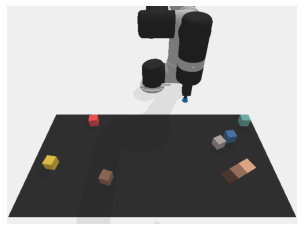

In [68]:
txt = "Is the yellow block on top of the red block?"
inputs = tokenizer_p([txt], return_tensors="pt").input_ids
img = Image.open('./samples/00.png')
patch_img = patch_resize_transform(img).unsqueeze(0)
img

### Pretrained

In [69]:
custom_gen = model_p.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)

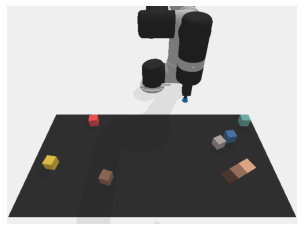

yellow block on top of red block no


In [70]:
display(img)
print(tokenizer_p.batch_decode(custom_gen, skip_special_tokens=True)[0].strip())

### Fine tuned

In [71]:
custom_gen_fin = model_f.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)

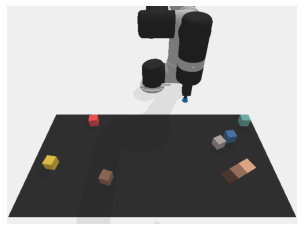

no


In [72]:
display(img)
print(tokenizer_p.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip())

## Push to hub

In [1]:
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig

In [5]:
fine_tuned ="/coc/scratch/sanisetty3/DLM/OFA-tiny-vqa-finetune/"
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-tiny/'

tokenizer_p = OFATokenizer.from_pretrained(fine_tuned)


/coc/scratch/sanisetty3/DLM/OFA-tiny-vqa-finetune/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [6]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /nethome/sanisetty3/.cache/huggingface/token
Login successful


In [8]:
!transformers-cli repo create OFA-tiny-vqa-finetune

WARNING! Managing repositories through transformers-cli is deprecated. Please use `huggingface-cli` instead.
git version 2.7.4
git-lfs/2.7.2 (GitHub; linux amd64; go 1.12.4)

Traceback (most recent call last):
  File "/srv/share2/sanisetty3/miniconda3/envs/DLM/bin/transformers-cli", line 8, in <module>
    sys.exit(main())
  File "/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/transformers/commands/transformers_cli.py", line 55, in main
    service.run()
  File "/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/transformers/commands/user.py", line 177, in run
    user, _ = whoami(token)
ValueError: too many values to unpack (expected 2)
